# Lectura del dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

import joblib

In [2]:
df_train = pd.read_csv('data/diabetes_prediction_dataset_train-labeled.csv')
df_test = pd.read_csv('data/diabetes_prediction_dataset_test.csv')
df = pd.concat([df_train, df_test])

In [3]:
plt.rcParams["font.size"] = 20

# Exploración

## Dataset

In [4]:
df

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0.0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0.0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0.0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0.0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0.0
...,...,...,...,...,...,...,...,...,...,...
4995,88540,Female,23.0,0,0,never,22.77,6.6,200,NaN
4996,26701,Female,51.0,0,0,No Info,27.32,4.0,155,NaN
4997,47271,Male,79.0,0,0,No Info,23.80,6.0,126,NaN
4998,97941,Male,24.0,0,0,never,22.68,6.1,85,NaN


Vemos que no hay nulos, salvo aquellos que fueron eliminados a propósito.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   patient              100000 non-null  int64  
 1   gender               100000 non-null  object 
 2   age                  100000 non-null  float64
 3   hypertension         100000 non-null  int64  
 4   heart_disease        100000 non-null  int64  
 5   smoking_history      100000 non-null  object 
 6   bmi                  100000 non-null  float64
 7   HbA1c_level          100000 non-null  float64
 8   blood_glucose_level  100000 non-null  int64  
 9   diabetes             95000 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 8.4+ MB


Separamos en variables numéricas y categóricas.

In [6]:
cat_cols = ['gender', 'smoking_history']
num_cols = [x for x in df.columns if x not in cat_cols and x not in ['patient', 'diabetes']]
# En las columnas numéricas quitamos la columna "patient" que contiene el id de los pacientes y "diabetes" que es la variable target

## Variables categóricas

Se puede observar que cada variable categórica posee pocas categorías. Además se observa que son variables nominales.

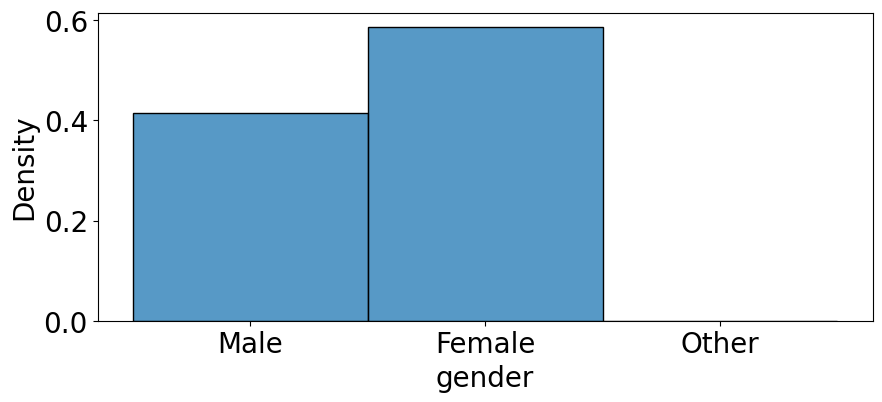

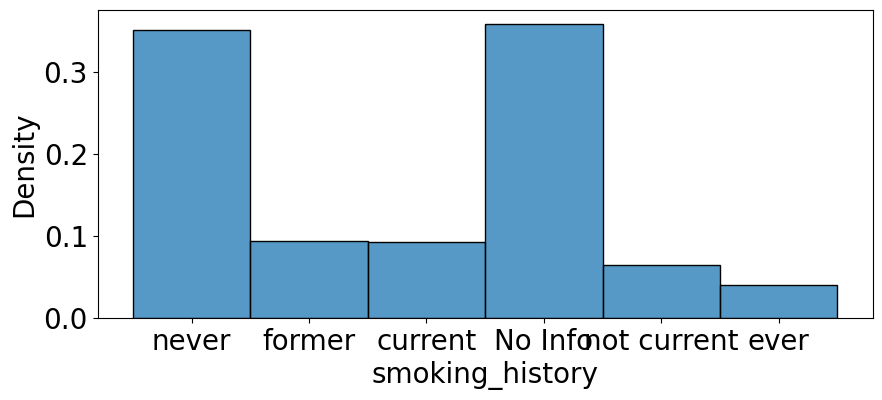

In [7]:
for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(data=df, x=col, stat='density')
    plt.show()

## Variables numéricas

En ningún caso se observan outliers significativos, por lo que se decide no realizar ninguna eliminación ni imputación.

In [8]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00


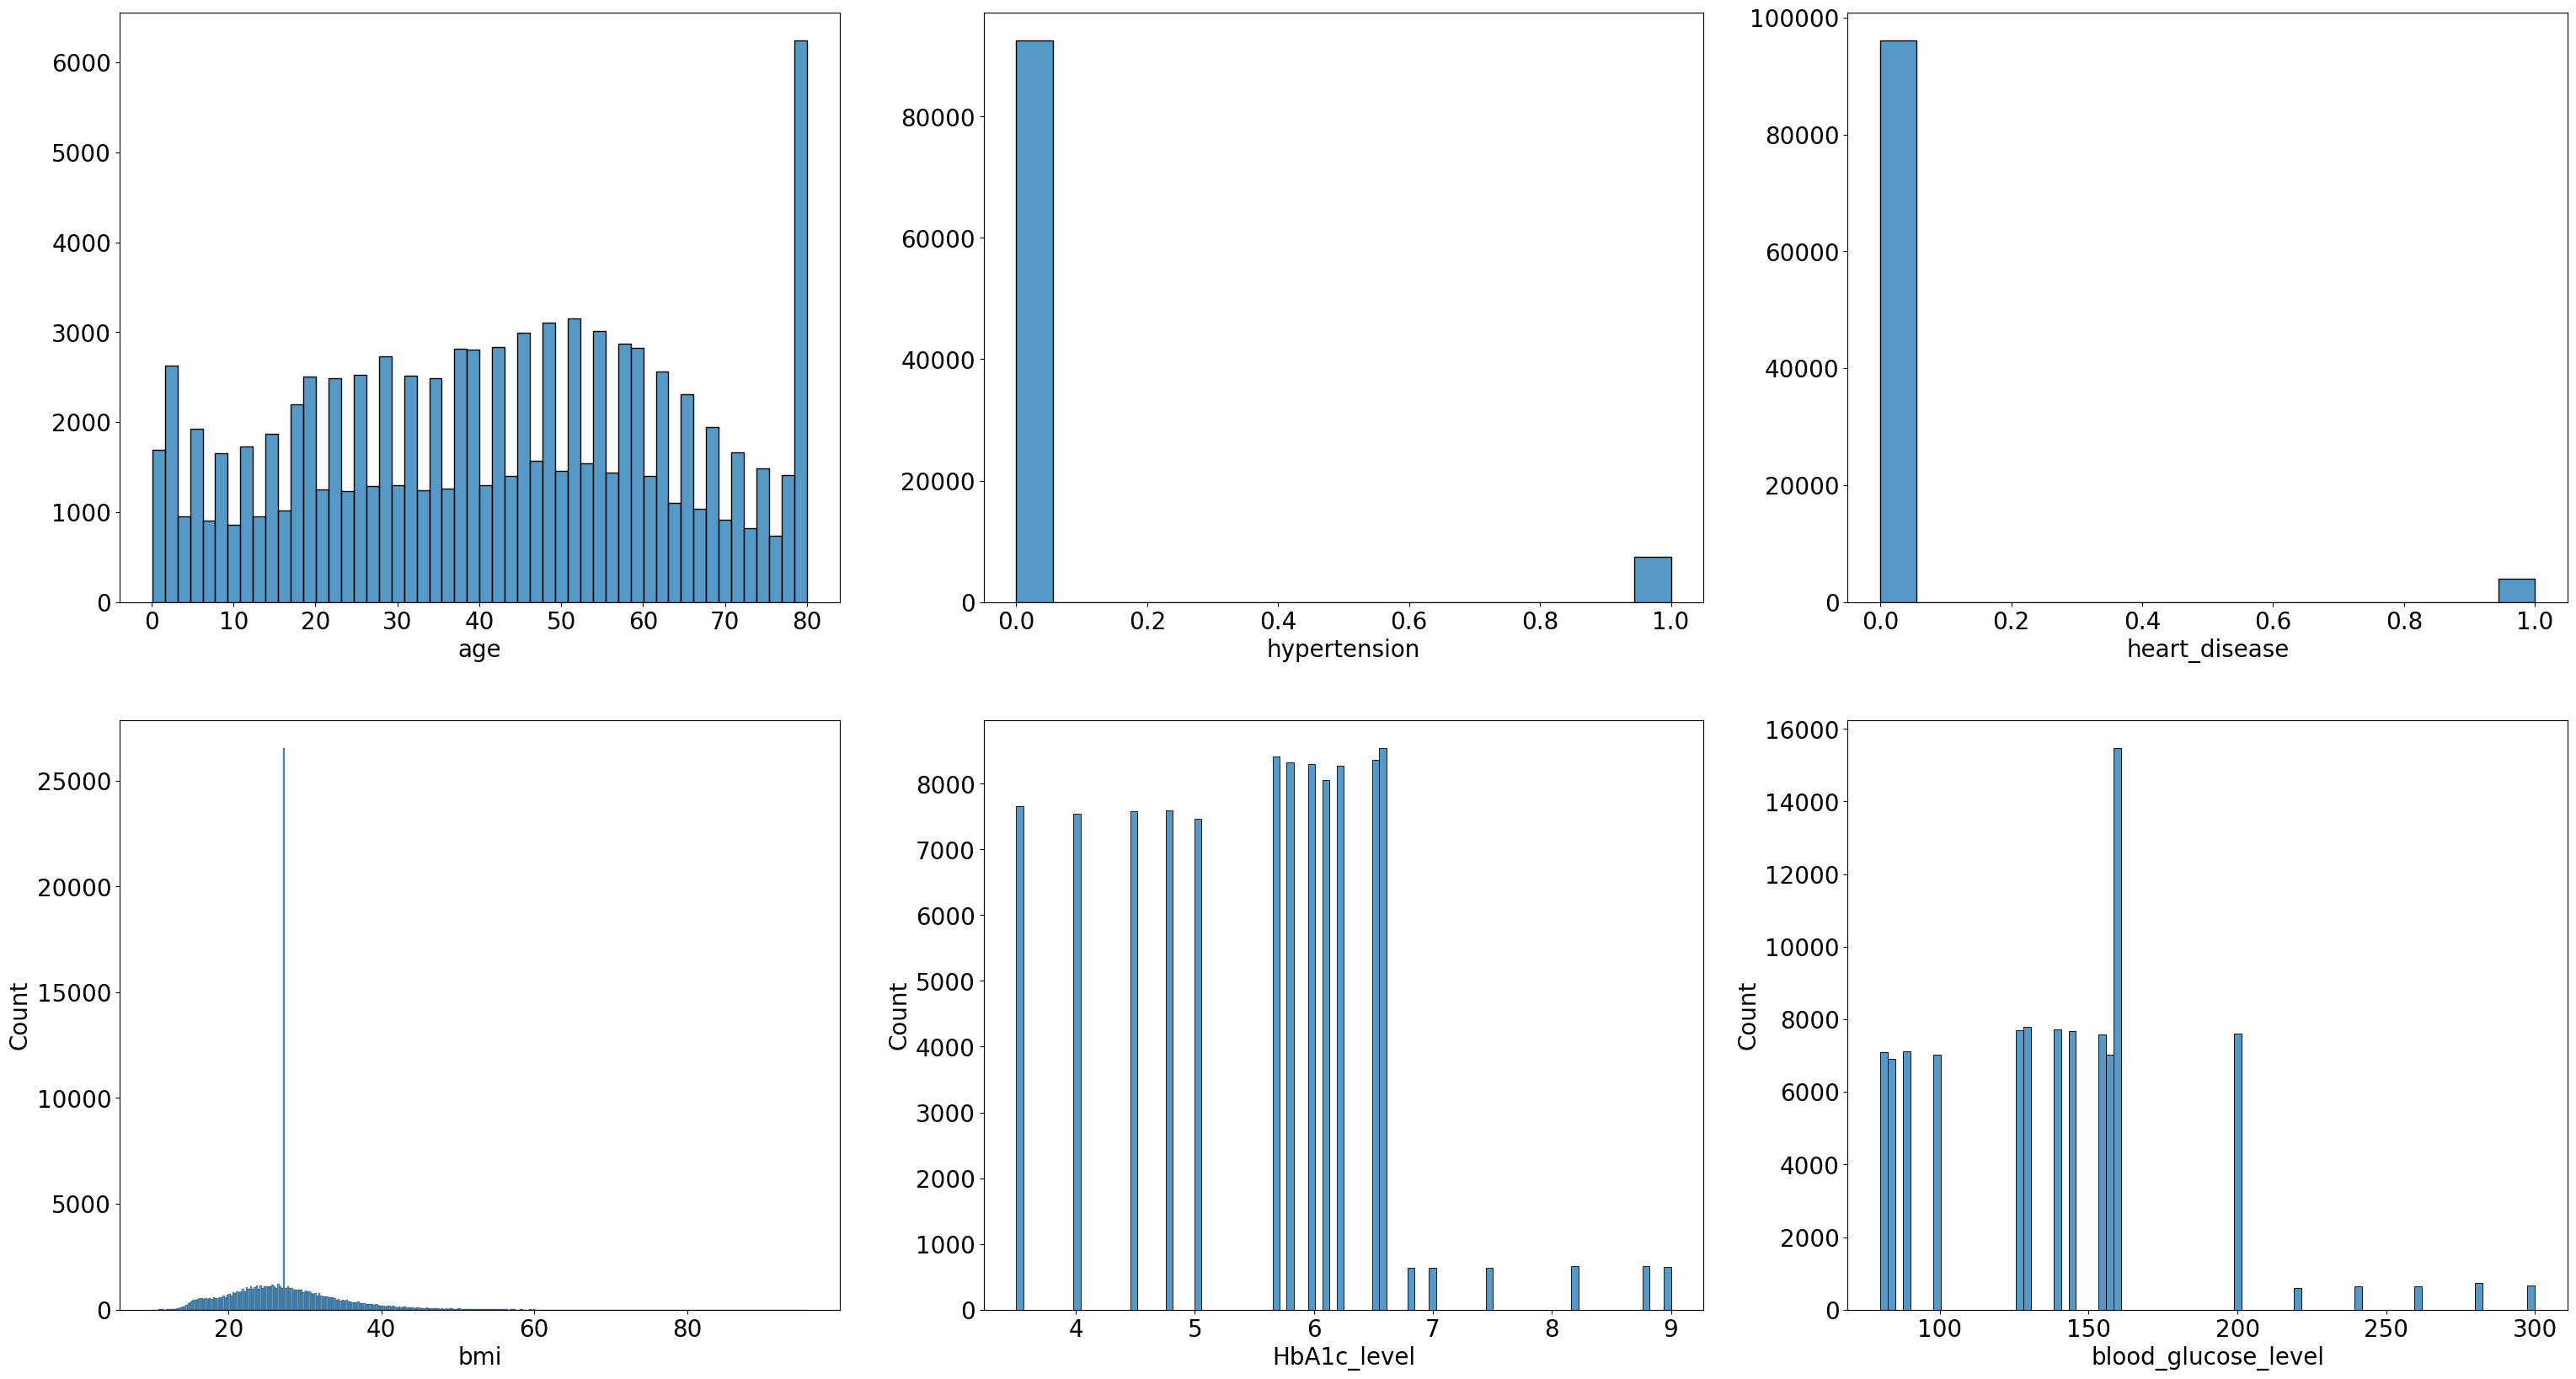

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(37.5, 20))
a = 0
for col in num_cols[:3]:
    sns.histplot(data=df, x=col, ax=axs[0, a])
    axs[0,a].set_ylabel('')
    a += 1

a = 0
for col in num_cols[3:]:
    sns.histplot(data=df, x=col, ax=axs[1, a])
    axs[0,a].set_ylabel('')
    a += 1

plt.show()

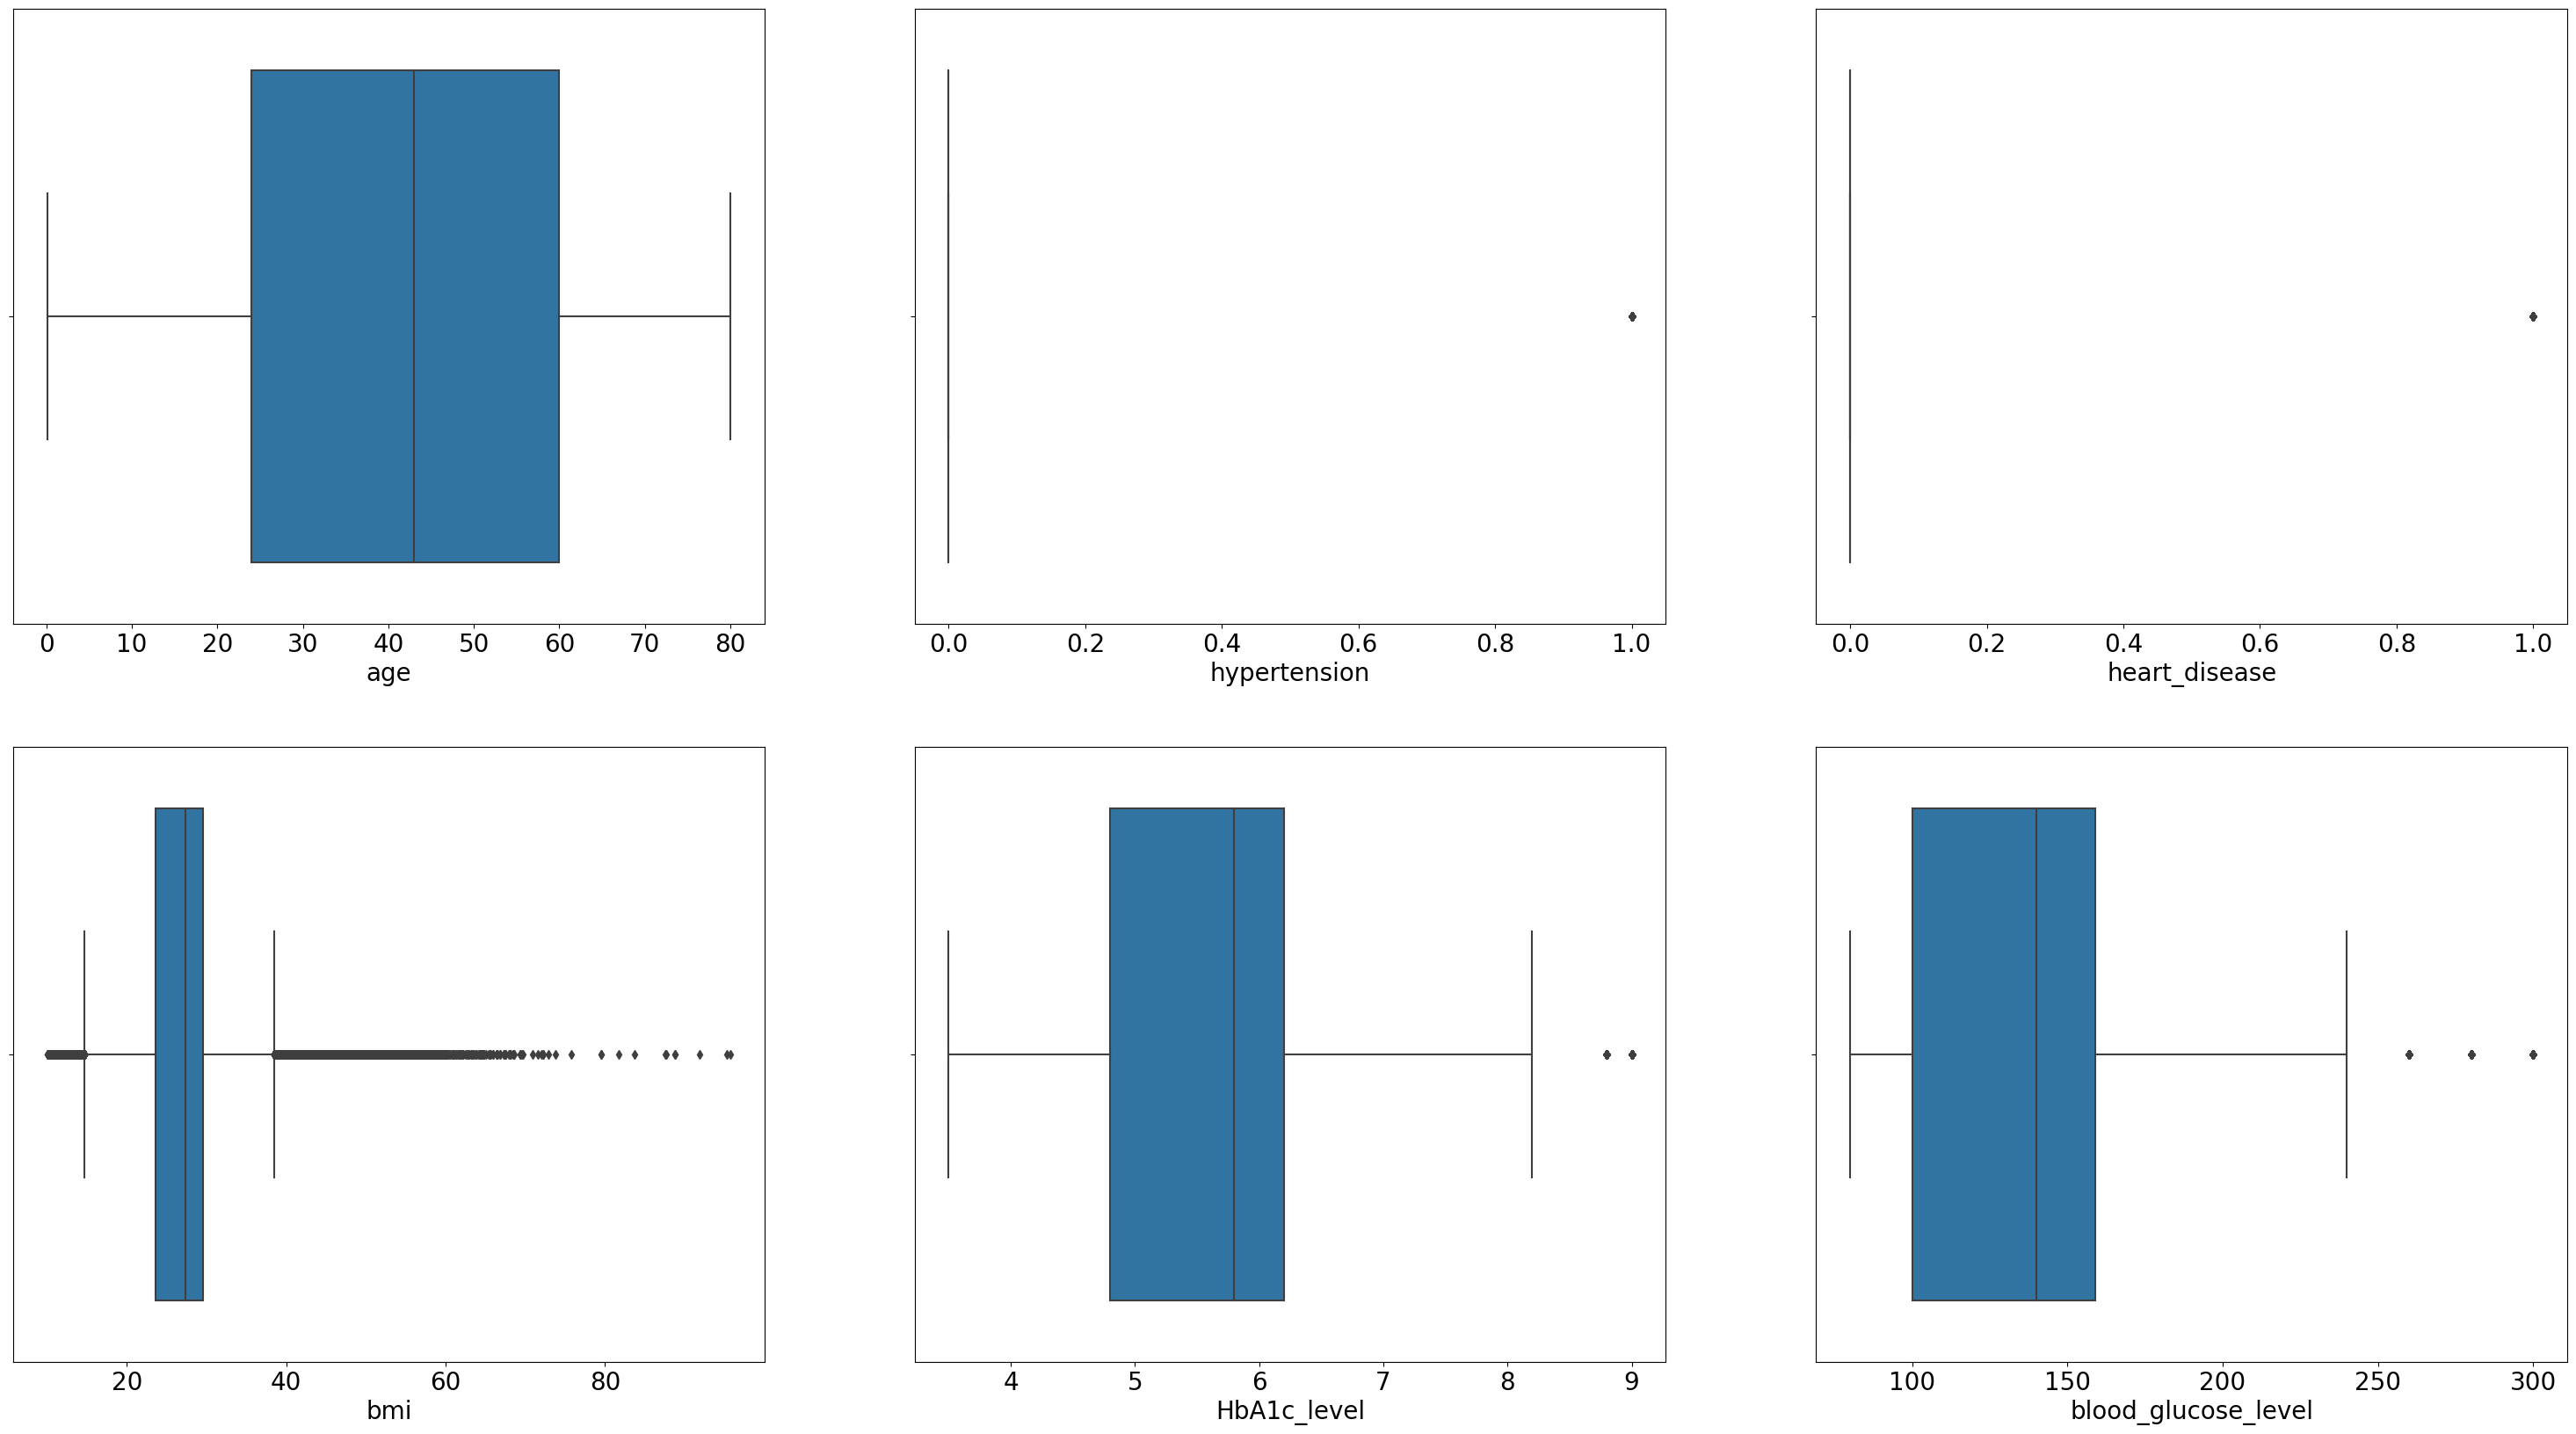

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(37.5, 20))
a = 0
for col in num_cols[:3]:
    sns.boxplot(data=df, x=col, ax=axs[0, a])
    axs[0,a].set_ylabel('')
    a += 1

a = 0
for col in num_cols[3:]:
    sns.boxplot(data=df, x=col, ax=axs[1, a])
    axs[0,a].set_ylabel('')
    a += 1

plt.show()

## Variable objetivo

Las clases están super desbalanceadas.

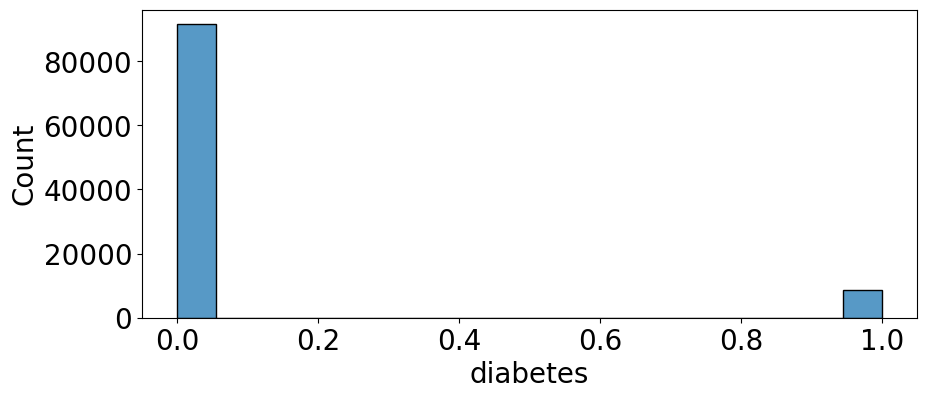

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='diabetes')
plt.show()

# Preprocesamiento

Armamos un pipeline de preprocesamiento, el cual se encarga de:
* Mapeamos las variables categíricas a numéricas utilizando one-hot encoding.
* Normalizamos las variables categóricas.

In [12]:
ohe = OneHotEncoder(drop='first')
scaler = StandardScaler()
pipeline = ColumnTransformer(
    [("OHE"  , ohe  , cat_cols),
     ("StandardScaler", scaler, num_cols)
    ]
  )
pipeline

ColumnTransformer(transformers=[('OHE', OneHotEncoder(drop='first'),
                                 ['gender', 'smoking_history']),
                                ('StandardScaler', StandardScaler(),
                                 ['age', 'hypertension', 'heart_disease', 'bmi',
                                  'HbA1c_level', 'blood_glucose_level'])])

In [13]:
pipeline = joblib.dump(pipeline, 'preproc_pipeline.pkl')